# Solving Time-Indepdendent PDEs

Created: 18 June 2021 <br/>
Last edited: 18 June 2021 <br/>
Teng-Jui Lin

Content adapted from UW CHEME 375, Chemical Engineering Computer Skills, in Spring 2021.

In this notebook, we explore the implementation of

- solving time-independent PDEs using finite difference method

## Time-independent 2D heat transfer
**Problem Statement.** We have a thin metal slab at steady-state, having different temperatures on its four sides. Determine the equilibrium temperature of the slab of points in the interval $[1, 3]\times[1, 3]$ with equal spacing of 1.

Given boundary conditions $T(0, y) = 75 \mathrm{^\circ C}, T(4, y) = 50 \mathrm{^\circ C}, T(x, 0) = 0 \mathrm{^\circ C}, T(x, 4) = 100 \mathrm{^\circ C}$.

### Analytic expression
**Solution.** We have the heat transport governing equation

$$
k\nabla^2 T + \dot{q} + \Phi = \rho C_V\dfrac{\partial T}{\partial t}
$$

where $\nabla^2 = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} + \frac{\partial^2}{\partial z^2}$.

Based on the problem statement, we have the assumptions:

- No heat source/generation
  - $\dot{q} = 0$
- No fluid or heat movement
  - $\Phi = 0$
- Steady-state system $\implies$ no time dependence
  - $\frac{\partial T}{\partial t} = 0$
- Thin metal slab $\implies$ 2D heat transfer (no heat transfer in $z$ direction)
  - $\frac{\partial^2 T}{\partial z^2} = 0$
- Constant thermal conductivity $\implies k \not= f(x, y, z, t)$
  - $k$ can be simplified

Therefore, we can simplify the governing equation:

$$
\begin{aligned}
k\nabla^2 T + \dot{q} + \Phi &= \rho C_V\dfrac{\partial T}{\partial t} \\
k\nabla^2 T &= 0 \\
\nabla^2 T &= 0 \\
\left(\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} + \frac{\partial^2}{\partial z^2}\right) T &= 0 \\
\frac{\partial^2T}{\partial x^2} + \frac{\partial^2T}{\partial y^2} &= 0
\end{aligned}
$$

### Numerical approximations
By central finite difference, we approximate the derivatives by

$$
\dfrac{\partial^2 T}{\partial x^2} \approx \dfrac{T_{i-1, j} - 2T_{i, j} + T_{i+1, j}}{\Delta x^2}
$$

$$
\dfrac{\partial^2 T}{\partial y^2} \approx \dfrac{T_{i, j-1} - 2T_{i, j} + T_{i, j+1}}{\Delta y^2}
$$

Assume that the spacing in $x$ and $y$ directions are the same $\Delta x = \Delta y = 1$, we have from the original equation:

$$
\begin{aligned}
\frac{\partial^2T}{\partial x^2} &+& \frac{\partial^2T}{\partial y^2} &= 0 \\
\dfrac{T_{i-1, j} - 2T_{i, j} + T_{i+1, j}}{\Delta x^2} &+& \dfrac{T_{i, j-1} - 2T_{i, j} + T_{i, j+1}}{\Delta y^2} &= 0 \\
T_{i-1, j} - 2T_{i, j} + T_{i+1, j} &+& T_{i, j-1} - 2T_{i, j} + T_{i, j+1} &= 0 \\
\end{aligned}
$$

For each point in the slab, we write out the expression from the above equation. We also replace the boundary conditions with numerical values. For example, at point $(i, j) = (1, 1)$, we have

$$
\begin{aligned}
T_{0, 1} - 2T_{1, 1} + T_{2, 1} + T_{1, 0} - 2T_{1, 1} + T_{1, 2} &= 0 \\
T_{0, 1} + T_{1, 0} - 4T_{1, 1} + T_{1, 2} + T_{2, 1} &= 0 \\
- 4T_{1, 1} + T_{1, 2} + T_{2, 1} &= -T_{0, 1} - T_{1, 0} \\
- 4T_{1, 1} + T_{1, 2} + T_{2, 1} &= -75 \\
\end{aligned}
$$

### From PDE to linear algebra

We can repeat the process for all the points. In this case, we have 9 points, therefore 9 equations and 9 unknowns:

$$
\begin{matrix}
+4T_{1,1} & -T_{2,1} & & -T_{1,2} & & & & & &=& 75 \\
-T_{1,1} & +4T_{2,1} & -T_{3,1} & & -T_{2,2} & & & & &=& 0 \\
& -T_{2,1} & +4T_{3,1} & & & -T_{3,2} & & & &=& 50 \\
-T_{1,1} & & & +4T_{1,2} & -T_{2,2} & & -T_{1,3} & & &=& 75 \\
& -T_{2,1} & & -T_{1,2} & +4T_{2,2} & -T_{3,2} & & -T_{2,3} & &=& 0 \\
& & -T_{3,1} & & -T_{2,2} & +4T_{3,2} & & & -T_{3,3} &=& 50 \\
& & & -T_{1,2} & & & +4T_{1,3} & -T_{2,3} & &=& 175 \\
& & & & -T_{2,2} & & -T_{1,3} & +4T_{2,3} & -T_{3,3} &=& 100 \\
& & & & & -T_{3,2} & & -T_{2,3} & +4T_{3,3} &=& 150 \\
\end{matrix}
$$

so we have the system $\mathbf{A}\mathbf{x} = \mathbf{b}$, where

$$
\mathbf{A} =
\begin{bmatrix}
+4 & -1 & & -1 & & & & & \\
-1 & +4 & -1 & & -1 & & & & \\
& -1 & +4 & & & -1 & & & \\
-1 & & & +4 & -1 & & -1 & & \\
& -1 & & -1 & +4 & -1 & & -1 & \\
& & -1 & & -1 & +4 & & & -1 \\
& & & -1 & & & +4 & -1 & \\
& & & & -1 & & -1 & +4 & -1 \\
& & & & & -1 & & -1 & +4 \\
\end{bmatrix},
\mathbf{x} =
\begin{bmatrix}
T_{1,1} \\ T_{2,1} \\ T_{3,1} \\ T_{1,2} \\ T_{2,2} \\ T_{3,2} \\ T_{1,3} \\ T_{2,3} \\ T_{3,3}
\end{bmatrix},
\mathbf{b} = \begin{bmatrix}
75 \\ 0 \\ 50 \\ 75 \\ 0 \\ 50 \\ 175 \\ 100 \\ 150
\end{bmatrix}
$$

We can then solve the system of linear equations.

### Implementation

In this approach, we use [`numpy.linalg.solve()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html) to solve the linear system obtained from simplifying the PDE.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# create the (sparse) matrix
A_size = 9
A = np.zeros((A_size, A_size))
for i in range(A_size):
    A[i, i] = 4

band_num = 4-1
for i in range(A_size-band_num):
    A[3+i, i] = -1
for i in range(A_size-band_num):
    A[i, 3+i] = -1

band_num = 2-1
for i in range(A_size-band_num):
    A[band_num+i, i] = -1
for i in range(A_size-band_num):
    A[i, band_num+i] = -1
    
for i in range(2, A_size-band_num, 3):
    A[band_num+i, i] = 0
for i in range(2, A_size-band_num, 3):
    A[i, band_num+i] = 0
A

array([[ 4., -1.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  4., -1.,  0., -1.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  4.,  0.,  0., -1.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  4., -1.,  0., -1.,  0.,  0.],
       [ 0., -1.,  0., -1.,  4., -1.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0., -1.,  4.,  0.,  0., -1.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  4., -1.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0., -1.,  4., -1.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0., -1.,  4.]])

In [3]:
b = np.array([75, 0, 50, 75, 0, 50, 175, 100, 150])

In [4]:
temperatures = np.linalg.solve(A, b)
temperatures

array([42.85714286, 33.25892857, 33.92857143, 63.16964286, 56.25      ,
       52.45535714, 78.57142857, 76.11607143, 69.64285714])

In [5]:
row = 3
col = 3
T_profile = temperatures.reshape(row, col)

In [6]:
for i in np.arange(6, -1, -3):
    print('{:.2f} | {:.2f} | {:.2f}'.format(*temperatures[i:i+3]))

78.57 | 76.12 | 69.64
63.17 | 56.25 | 52.46
42.86 | 33.26 | 33.93


### Plotting annotated heatmap

In [7]:
# plot settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams.update({
    'font.family': 'Arial',  # Times New Roman, Calibri
    'font.weight': 'normal',
    'mathtext.fontset': 'cm',
    'font.size': 18,
    
    'lines.linewidth': 2,
    
    'axes.linewidth': 2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.titleweight': 'bold',
    'axes.titlesize': 18,
    'axes.labelweight': 'bold',
    
    'xtick.major.size': 8,
    'xtick.major.width': 2,
    'ytick.major.size': 8,
    'ytick.major.width': 2,
    
    'figure.dpi': 80,
    
    'legend.framealpha': 1, 
    'legend.edgecolor': 'black',
    'legend.fancybox': False,
    'legend.fontsize': 14
})

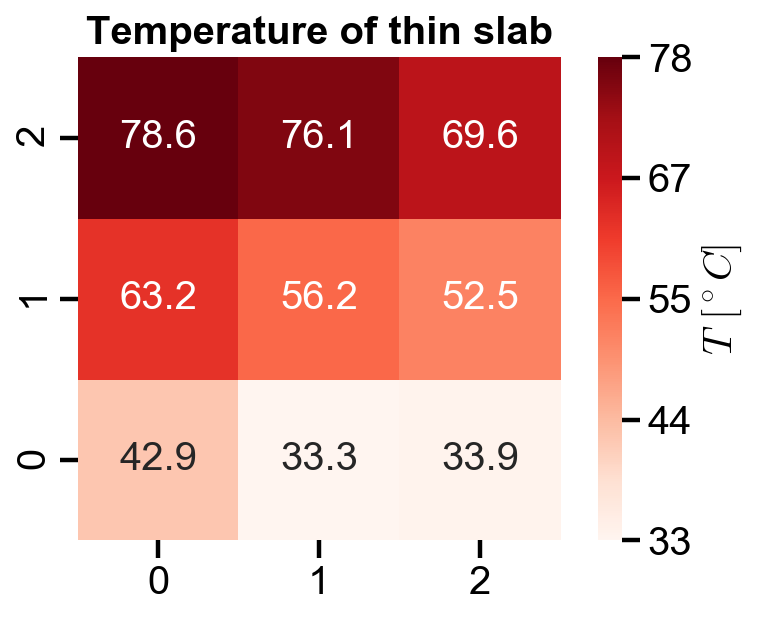

In [8]:
import seaborn as sns
T_heatmap = sns.heatmap(T_profile, square=True, cbar=True,
                        annot=True, fmt=".1f", cmap='Reds',
                        cbar_kws={'label': '$T \ [^\circ C]$', 
                                  'format': '%i', 
                                  'ticks': np.linspace(temperatures.min(), temperatures.max(), 5)})
T_heatmap.set_title('Temperature of thin slab')
T_heatmap.invert_yaxis()